In [43]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

import sys

import grade_tools as gt

import seaborn as sns

import os


# For mailing
import smtplib
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from email.mime.multipart import MIMEMultipart
import base64
import ssl
import getpass


In [2]:
infile = 'PHYS_260_Thermal_Physics_S23.csv'

df = pd.read_csv(infile)

In [3]:
print(df)

# Drop Enzo
df = df[~(df['Last Name']=='Morina')]

df

   Last Name   First Name       Email Address  \
0       Date          NaN                 NaN   
1     Points          NaN                 NaN   
2    Cestero      Anthony  ar21cest@siena.edu   
3      Perez  Christopher  cj15pere@siena.edu   
4   Pezzella  Christopher  cj08pezz@siena.edu   
5    Morrell       Daniel   d16morr@siena.edu   
6     Herron      Etienne  ea17herr@siena.edu   
7    Cochran        Jaime  jr02coch@siena.edu   
8       Siji       Jeremy  jm07siji@siena.edu   
9       Cola      Jillian  jf21cola@siena.edu   
10    Likens       Joseph  jv29like@siena.edu   
11     Swann    Josephine  jr21swan@siena.edu   
12   Velardi      Kaitlyn  ka02vela@siena.edu   
13  Flaherty        Keira  km10flah@siena.edu   
14  Giordano      Maxwell  mp07gior@siena.edu   
15  Mathurin     Mirnelle  mc12math@siena.edu   
16    Dubson     Mitchell   m07dubs@siena.edu   
17     Adams        Shawn  se17adam@siena.edu   
18    Morina     Vincenzo  vf13mori@siena.edu   

   PLEASE SIGN: Aca

,Last Name,First Name,Email Address,PLEASE SIGN: Academic integrity statement,PLEASE SIGN: Classroom code of conduct,QUIZ: Syllabus quiz,READING: Chapter 1 (1.1-1.2),SURVEY: Getting to know you,SURVEY: Poll for drop-in hours,"WATCH ""The Biggest Myth in Education""",...,QUIZ: Chapter 1b,"READING: Chapter 3 ""Interactions and Implications"" (3.1)",QUIZ: Chapter 2a,IN-CLASS ACTIVITY: Chapter 2,"PARTICIPATION AND ENGAGEMENT: Perusall, in-class engagement, summary document",HOMEWORK: Chapter 2b,"READING: Chapter 3 ""Interactions and Implications"" (3.2)",HOMEWORK: Chapter 3a,IN-CLASS ACTIVITY: Chapter 3,HOMEWORK: Chapter 3b
0,Date,NaN,NaN,"Jan 24, 2023","Jan 24, 2023","Jan 24, 2023","Jan 24, 2023","Jan 24, 2023","Jan 24, 2023","Jan 24, 2023",...,"Feb 9, 2023","Feb 16, 2023","Feb 16, 2023","Feb 16, 2023","Feb 16, 2023","Feb 21, 2023","Feb 21, 2023","Mar 7, 2023","Mar 7, 2023","Mar 14, 2023"
1,Points,NaN,NaN,NaN,NaN,280.0,NaN,NaN,NaN,NaN,...,60.0,NaN,50.0,NaN,5.0,100.0,NaN,20.0,NaN,40.0
2,Cestero,Anthony,ar21cest@siena.edu,NaN,NaN,270.0,NaN,NaN,NaN,NaN,...,30.0,NaN,35.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,Perez,Christopher,cj15pere@siena.edu,NaN,NaN,250.0,NaN,NaN,NaN,NaN,...,20.0,NaN,20.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,Pezzella,Christopher,cj08pezz@siena.edu,NaN,NaN,250.0,NaN,NaN,NaN,NaN,...,50.0,NaN,40.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN
5,Morrell,Daniel,d16morr@siena.edu,NaN,NaN,270.0,NaN,NaN,NaN,NaN,...,30.0,NaN,50.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
6,Herron,Etienne,ea17herr@siena.edu,NaN,NaN,280.0,NaN,NaN,NaN,NaN,...,20.0,NaN,35.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
7,Cochran,Jaime,jr02coch@siena.edu,NaN,NaN,280.0,NaN,NaN,NaN,NaN,...,20.0,NaN,35.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN
8,Siji,Jeremy,jm07siji@siena.edu,NaN,NaN,260.0,NaN,NaN,NaN,NaN,...,40.0,NaN,35.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
9,Cola,Jillian,jf21cola@siena.edu,NaN,NaN,260.0,NaN,NaN,NaN,NaN,...,50.0,NaN,40.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN


In [4]:
lnames = df['Last Name'].values
fnames = df['First Name'].values

print(lnames)
print(fnames)

['Date' 'Points' 'Cestero' 'Perez' 'Pezzella' 'Morrell' 'Herron' 'Cochran'
 'Siji' 'Cola' 'Likens' 'Swann' 'Velardi' 'Flaherty' 'Giordano' 'Mathurin'
 'Dubson' 'Adams']
[nan nan 'Anthony' 'Christopher' 'Christopher' 'Daniel' 'Etienne' 'Jaime'
 'Jeremy' 'Jillian' 'Joseph' 'Josephine' 'Kaitlyn' 'Keira' 'Maxwell'
 'Mirnelle' 'Mitchell' 'Shawn']


In [5]:
mask = (df['Last Name']=='Cestero') & (df['First Name']=='Anthony')

dft = df[mask]

print(dft)

  Last Name First Name       Email Address  \
2   Cestero    Anthony  ar21cest@siena.edu   

  PLEASE SIGN: Academic integrity statement  \
2                                       NaN   

  PLEASE SIGN: Classroom code of conduct QUIZ: Syllabus quiz  \
2                                    NaN               270.0   

  READING: Chapter 1 (1.1-1.2) SURVEY: Getting to know you  \
2                          NaN                         NaN   

  SURVEY: Poll for drop-in hours WATCH "The Biggest Myth in Education"  ...  \
2                            NaN                                   NaN  ...   

  QUIZ: Chapter 1b READING: Chapter 3 "Interactions and Implications" (3.1)  \
2             30.0                                                NaN         

  QUIZ: Chapter 2a IN-CLASS ACTIVITY: Chapter 2  \
2             35.0                          NaN   

  PARTICIPATION AND ENGAGEMENT: Perusall, in-class engagement, summary document  \
2                                                0.0  

In [6]:
for fname,lname in zip(fnames,lnames):
    print(f'{fname} {lname}')
    print(f'{type(fname)} {type(lname)}')

    if type(lname)!=str or type(fname)!=str:
        print("Continuing")
        continue
    
    print(lname,fname)
    mask = (df['Last Name']==lname) & (df['First Name']==fname)
    print(mask)
    dftemp = df[mask]
    print(dftemp)
    print(df[mask])
    print()


nan Date
<class 'float'> <class 'str'>
Continuing
nan Points
<class 'float'> <class 'str'>
Continuing
Anthony Cestero
<class 'str'> <class 'str'>
Cestero Anthony
0     False
1     False
2      True
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
dtype: bool
  Last Name First Name       Email Address  \
2   Cestero    Anthony  ar21cest@siena.edu   

  PLEASE SIGN: Academic integrity statement  \
2                                       NaN   

  PLEASE SIGN: Classroom code of conduct QUIZ: Syllabus quiz  \
2                                    NaN               270.0   

  READING: Chapter 1 (1.1-1.2) SURVEY: Getting to know you  \
2                          NaN                         NaN   

  SURVEY: Poll for drop-in hours WATCH "The Biggest Myth in Education"  ...  \
2                            NaN                                   NaN  ...   

  QUIZ: C

In [7]:
def get_assignments(df):
    
    maps = {'quiz':['QUIZ'], 'hw':['HW', 'HOMEWORK'], "participation":['PARTICIPATION', 'participation']}

    colnames = df.columns

    assignments = {"name":[], "points":[], "date":[], "type":[]}
    
    #assignments['part'] = {'name':[], 'date':[], 'points': []}
    #assignments['quiz'] = {'name':[], 'date':[], 'points': []}
    #assignments['hw'] = {'name':[], 'date':[], 'points': []}
    #assignments['midterm'] = {'name':[], 'date':[], 'points': []}
    #assignments['final'] = {'name':[], 'date':[], 'points': []}
    #assignments['extracredit'] = {'name':[], 'date':[], 'points': []}

    for name in colnames:
        #print(name, " -----")
        for key in maps.keys():
            #print(key)
            MATCH = False
            for val in maps[key]:
                #print(val)
                if name.find(val)>=0:
                    MATCH = True
            #print(MATCH,name,key,val)            
            if MATCH:
                points = df[name].iloc[1]
                #print(type(points))
                if type(points)!=str:
                    continue
                assignments['name'].append(name)
                assignments['type'].append(key)
                assignments['date'].append(df[name].iloc[0])
                assignments['points'].append(float(points))
    
    dfa = pd.DataFrame.from_dict(assignments)
    return dfa
            
'''
            hwandquizinfo[name] = []
        # EDAV
        elif name.find('HW')>=0 or name.find('HOMEWORK')>=0 or name.find('CLASS')>=0:
        # Quantum
        #elif name.find('HW')>=0 or name.find('HOMEWORK')>=0 or name.find('CODING')>=0:
            hwinfo[name] = []
            hwandquizinfo[name] = []
        elif name.find('PARTICIPATION')>=0 or name.find('PARTICIPATION')>=0:
            partinfo[name] = []
        elif name.find('EXTRA')>=0:
            extracreditinfo[name] = []
        elif name.find('MID')>=0:
            midterminfo[name] = []
        elif name.find('FINAL')>=0:
            finalinfo[name] = []
'''

dfa = get_assignments(df)

dfa


,name,points,date,type
0,QUIZ: Syllabus quiz,280.0,"Jan 24, 2023",quiz
1,HOMEWORK: Chapter 1a,42.0,"Jan 26, 2023",hw
2,HOMEWORK: Chapter 1b,50.0,"Feb 2, 2023",hw
3,QUIZ: Chapter 1a,40.0,"Feb 2, 2023",quiz
4,HOMEWORK: Chapter 2a,40.0,"Feb 9, 2023",hw
5,QUIZ: Chapter 1b,60.0,"Feb 9, 2023",quiz
6,QUIZ: Chapter 2a,50.0,"Feb 16, 2023",quiz
7,"PARTICIPATION AND ENGAGEMENT: Perusall, in-cla...",5.0,"Feb 16, 2023",participation
8,HOMEWORK: Chapter 2b,100.0,"Feb 21, 2023",hw
9,HOMEWORK: Chapter 3a,20.0,"Mar 7, 2023",hw


In [8]:
mask = dfa['type']=='quiz'
dfa[mask]

,name,points,date,type
0,QUIZ: Syllabus quiz,280.0,"Jan 24, 2023",quiz
3,QUIZ: Chapter 1a,40.0,"Feb 2, 2023",quiz
5,QUIZ: Chapter 1b,60.0,"Feb 9, 2023",quiz
6,QUIZ: Chapter 2a,50.0,"Feb 16, 2023",quiz


In [9]:
def represents_float(s):
    try: 
        float(s)
    except ValueError:
        return False
    else:
        return True

In [10]:
dfa

,name,points,date,type
0,QUIZ: Syllabus quiz,280.0,"Jan 24, 2023",quiz
1,HOMEWORK: Chapter 1a,42.0,"Jan 26, 2023",hw
2,HOMEWORK: Chapter 1b,50.0,"Feb 2, 2023",hw
3,QUIZ: Chapter 1a,40.0,"Feb 2, 2023",quiz
4,HOMEWORK: Chapter 2a,40.0,"Feb 9, 2023",hw
5,QUIZ: Chapter 1b,60.0,"Feb 9, 2023",quiz
6,QUIZ: Chapter 2a,50.0,"Feb 16, 2023",quiz
7,"PARTICIPATION AND ENGAGEMENT: Perusall, in-cla...",5.0,"Feb 16, 2023",participation
8,HOMEWORK: Chapter 2b,100.0,"Feb 21, 2023",hw
9,HOMEWORK: Chapter 3a,20.0,"Mar 7, 2023",hw


In [11]:
names = dfa['name']

dfplot = {"name":[], "scores":[], "type":[]}

for name in names:
    #print(name)
    dftemp = df[name]
    x = dftemp.values[2:] # Skip first two rows which are date and total points
    #print(x[0],represents_float(x[0]))
    if represents_float(x[0]):
        x = x.astype(float)
        #print(x)
        #print(len(x))
        if x[0]==x[0]:

            points = dfa[dfa['name']==name]['points'].values[0]
    
            
            dfplot["name"] += len(x)*[name]
            dfplot['scores'] += (x/points).tolist()
            
            atype = dfa[dfa['name']==name]['type'].values[0]
            dfplot['type'] += len(x)*[atype]

            #plt.figure()
            #plt.hist(x)

dfplot = pd.DataFrame.from_dict(dfplot)

In [12]:
dfplot

,name,scores,type
0,QUIZ: Syllabus quiz,0.964286,quiz
1,QUIZ: Syllabus quiz,0.892857,quiz
2,QUIZ: Syllabus quiz,0.892857,quiz
3,QUIZ: Syllabus quiz,0.964286,quiz
4,QUIZ: Syllabus quiz,1.000000,quiz
...,...,...,...
123,"PARTICIPATION AND ENGAGEMENT: Perusall, in-cla...",0.800000,participation
124,"PARTICIPATION AND ENGAGEMENT: Perusall, in-cla...",0.400000,participation
125,"PARTICIPATION AND ENGAGEMENT: Perusall, in-cla...",1.000000,participation
126,"PARTICIPATION AND ENGAGEMENT: Perusall, in-cla...",0.000000,participation


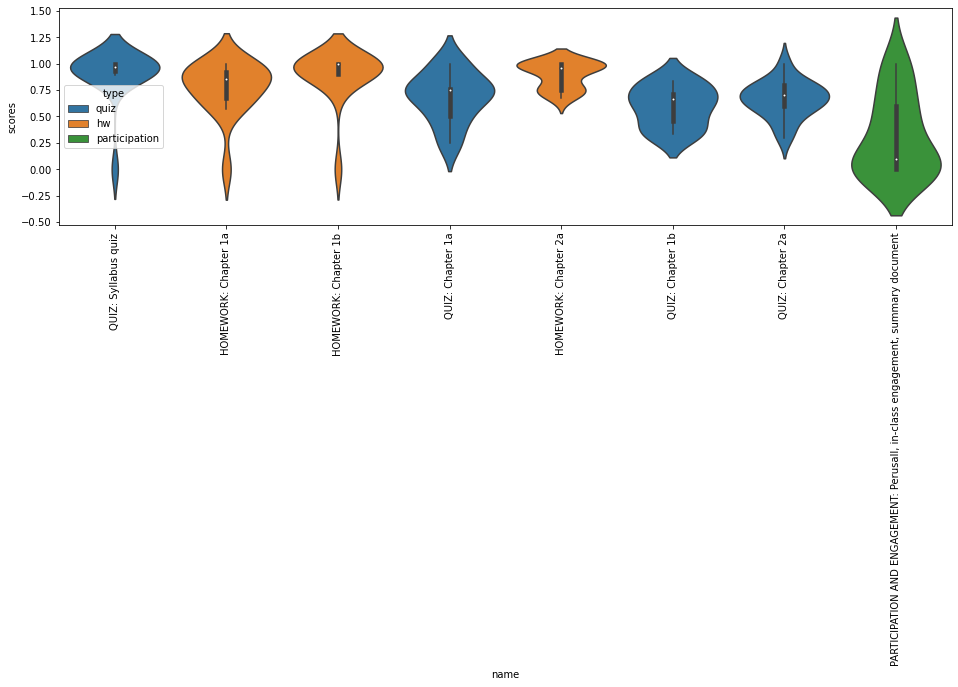

In [13]:
plt.figure(figsize=(16,4))

sns.violinplot(data=dfplot, y="scores", x="name", hue='type', dodge=False);

plt.xticks(rotation=90);

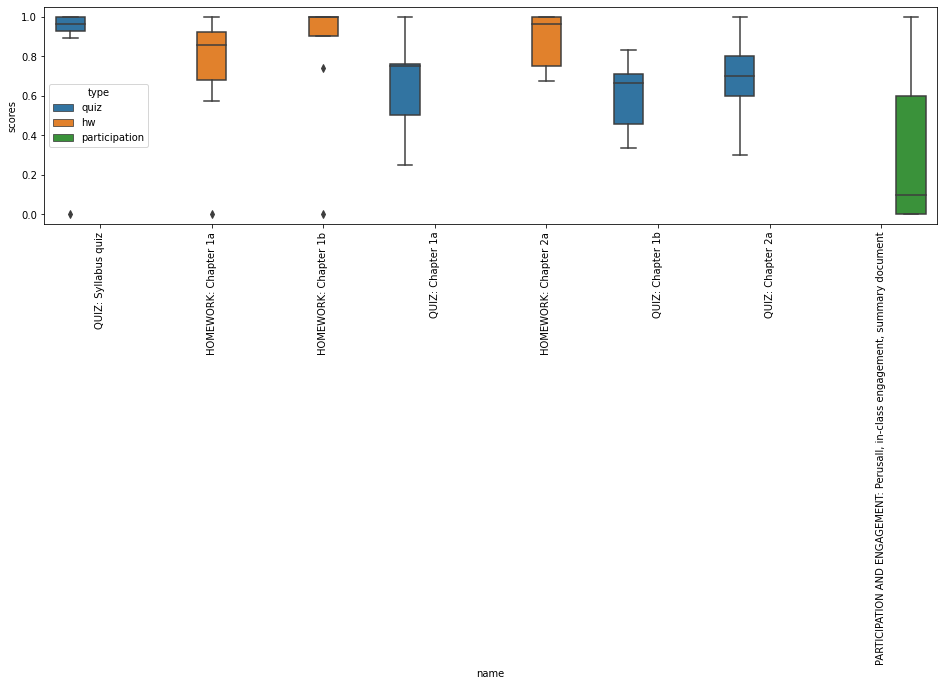

In [14]:
plt.figure(figsize=(16,4))

sns.boxplot(data=dfplot, y="scores", x="name", hue='type');

plt.xticks(rotation=90);

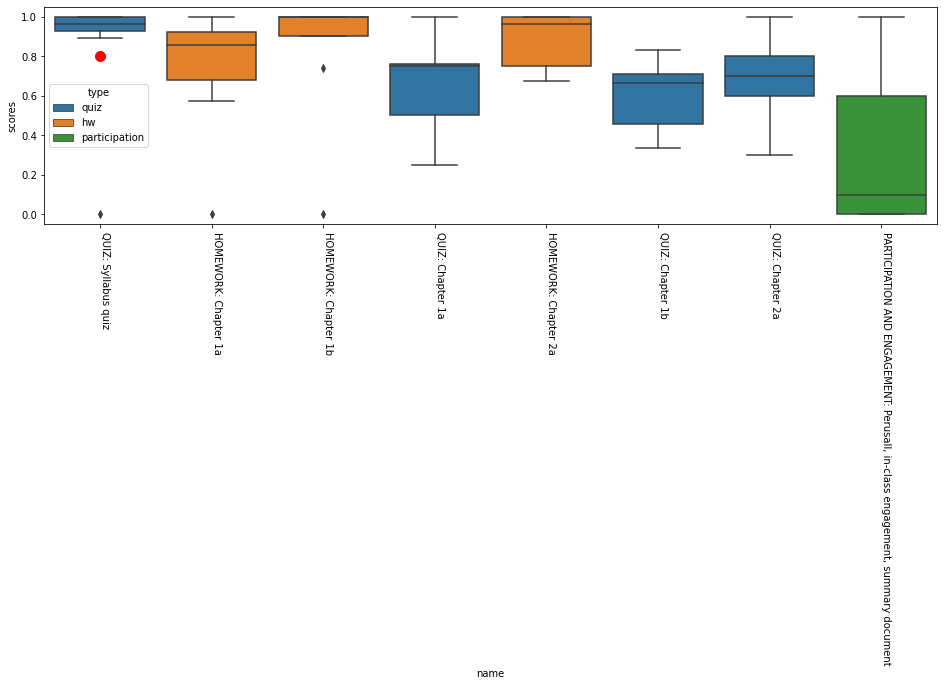

In [15]:
plt.figure(figsize=(16,4))

sns.boxplot(data=dfplot, y="scores", x="name", hue='type', dodge=False);

plt.plot([0],[0.8],'ro',markersize=10);

plt.xticks(rotation=270,ha='left');

Text(0, 0, 'QUIZ: Syllabus quiz')
QUIZ: Syllabus quiz
Text(1, 0, 'HOMEWORK: Chapter 1a')
HOMEWORK: Chapter 1a
Text(2, 0, 'HOMEWORK: Chapter 1b')
HOMEWORK: Chapter 1b
Text(3, 0, 'QUIZ: Chapter 1a')
QUIZ: Chapter 1a
Text(4, 0, 'HOMEWORK: Chapter 2a')
HOMEWORK: Chapter 2a
Text(5, 0, 'QUIZ: Chapter 1b')
QUIZ: Chapter 1b
Text(6, 0, 'QUIZ: Chapter 2a')
QUIZ: Chapter 2a
Text(7, 0, 'PARTICIPATION AND ENGAGEMENT: Perusall, in-class engagement, summary document')
PARTICIPATION AND ENGAGEMENT: Perusall, in-class engagement, summary document



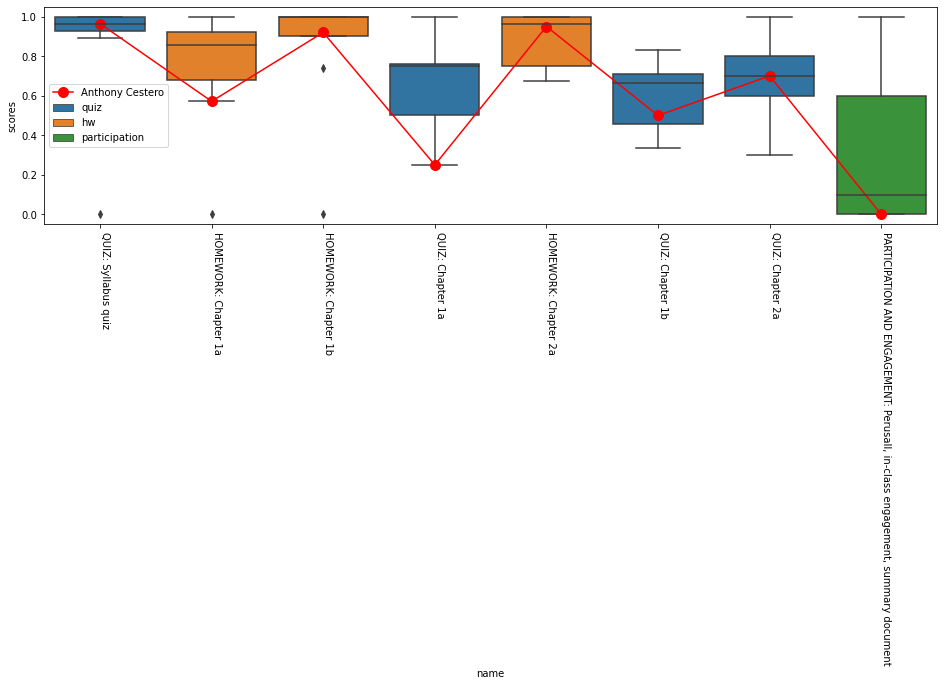

In [16]:
anames = np.unique(dfplot['name'])

plt.figure(figsize=(16,4))

sns.boxplot(data=dfplot, y="scores", x="name", hue='type', dodge=False);

xlabels = plt.gca().get_xticklabels(which='both')

n = 2

xpts = []
ypts = []

output = ""
for idx,xlabel in enumerate(xlabels):
    print(xlabel)
    name = xlabel.get_text()
    print(name)
    org_score = float(df.iloc[n][name])
    points = dfa[dfa['name']==name]['points'].values[0]
    score = org_score/points
    xpts.append(name)
    ypts.append(score)
    
    
lname = df.iloc[n]['Last Name']
fname = df.iloc[n]['First Name']
email = df.iloc[n]['Email Address']

print()

plt.plot(xpts,ypts,'ro-',markersize=10, label=f'{fname} {lname}');

plt.xticks(rotation=270,ha='left');
plt.legend()





In [17]:
#xlabel.

In [18]:
df.iloc[2]['Last Name']

'Cestero'

In [19]:
df.iloc[2]

Last Name                                                                                   Cestero
First Name                                                                                  Anthony
Email Address                                                                    ar21cest@siena.edu
PLEASE SIGN: Academic integrity statement                                                       NaN
PLEASE SIGN: Classroom code of conduct                                                          NaN
QUIZ: Syllabus quiz                                                                           270.0
READING: Chapter 1 (1.1-1.2)                                                                    NaN
SURVEY: Getting to know you                                                                     NaN
SURVEY: Poll for drop-in hours                                                                  NaN
WATCH "The Biggest Myth in Education"                                                           NaN


https://medium.com/dunder-data/automatically-wrap-graph-labels-in-matplotlib-and-seaborn-a48740bc9ce

In [20]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

In [21]:
weighting = {"quiz":0.45, "hw": 0.20, "participation":0.05}
weighting_sum = 0
for key in weighting.keys():
    weighting_sum += weighting[key]
    
print(f"Weighting sum: {weighting_sum}")


Weighting sum: 0.7000000000000001


In [22]:
dfa

,name,points,date,type
0,QUIZ: Syllabus quiz,280.0,"Jan 24, 2023",quiz
1,HOMEWORK: Chapter 1a,42.0,"Jan 26, 2023",hw
2,HOMEWORK: Chapter 1b,50.0,"Feb 2, 2023",hw
3,QUIZ: Chapter 1a,40.0,"Feb 2, 2023",quiz
4,HOMEWORK: Chapter 2a,40.0,"Feb 9, 2023",hw
5,QUIZ: Chapter 1b,60.0,"Feb 9, 2023",quiz
6,QUIZ: Chapter 2a,50.0,"Feb 16, 2023",quiz
7,"PARTICIPATION AND ENGAGEMENT: Perusall, in-cla...",5.0,"Feb 16, 2023",participation
8,HOMEWORK: Chapter 2b,100.0,"Feb 21, 2023",hw
9,HOMEWORK: Chapter 3a,20.0,"Mar 7, 2023",hw


In [23]:
n = 2

dfstudent = df.iloc[2]

dfstudent

Last Name                                                                                   Cestero
First Name                                                                                  Anthony
Email Address                                                                    ar21cest@siena.edu
PLEASE SIGN: Academic integrity statement                                                       NaN
PLEASE SIGN: Classroom code of conduct                                                          NaN
QUIZ: Syllabus quiz                                                                           270.0
READING: Chapter 1 (1.1-1.2)                                                                    NaN
SURVEY: Getting to know you                                                                     NaN
SURVEY: Poll for drop-in hours                                                                  NaN
WATCH "The Biggest Myth in Education"                                                           NaN


In [24]:
n = 2

dfstudent = df.iloc[2]

#print(dfstudent)
#print()

nassignments = len(dfa)

scores = {}
for key in weighting.keys():
    scores[key] = []
print(scores)

for n in range(nassignments):
    aname = dfa.iloc[n]['name']
    atype = dfa.iloc[n]['type']
    points = dfa.iloc[n]['points']
    date = dfa.iloc[n]['date']
    
    org_score = float(dfstudent[aname])
    if org_score != org_score:
        continue
        
    score = org_score / points
    scores[atype].append(score)
    
    
print(scores)
    

{'quiz': [], 'hw': [], 'participation': []}
QUIZ: Syllabus quiz quiz 280.0 Jan 24, 2023 0.9642857142857143
HOMEWORK: Chapter 1a hw 42.0 Jan 26, 2023 0.5714285714285714
HOMEWORK: Chapter 1b hw 50.0 Feb 2, 2023 0.92
QUIZ: Chapter 1a quiz 40.0 Feb 2, 2023 0.25
HOMEWORK: Chapter 2a hw 40.0 Feb 9, 2023 0.95
QUIZ: Chapter 1b quiz 60.0 Feb 9, 2023 0.5
QUIZ: Chapter 2a quiz 50.0 Feb 16, 2023 0.7
PARTICIPATION AND ENGAGEMENT: Perusall, in-class engagement, summary document participation 5.0 Feb 16, 2023 0.0
{'quiz': [0.9642857142857143, 0.25, 0.5, 0.7], 'hw': [0.5714285714285714, 0.92, 0.95], 'participation': [0.0]}


In [25]:
def average_scores(scores, weighting):
    weight_sum = 0
    what_was_included = []
    
    tot = 0
    
    for key in scores:
        if len(scores[key])>0:
            if key not in what_was_included:
                weight_sum += weighting[key]
                what_was_included.append(key)
            ave = np.average(scores[key])
            w = weighting[key]
            
            #print(scores[key], ave, w)

            tot += ave*w
    
    #print(tot, weight_sum)
    tot /= weight_sum
    #print(tot)
    return tot

In [26]:
average_scores(scores,weighting)

0.6205272108843537

Summary grades for Anthony Cestero (ar21cest@siena.edu)

QUIZ: Syllabus quiz            quiz       Jan 24, 2023    96.43 (270.0/280.0)
HOMEWORK: Chapter 1a           hw         Jan 26, 2023    57.14 (24.0/42.0)
HOMEWORK: Chapter 1b           hw         Feb 2, 2023     92.00 (46.0/50.0)
QUIZ: Chapter 1a               quiz       Feb 2, 2023     25.00 (10.0/40.0)
HOMEWORK: Chapter 2a           hw         Feb 9, 2023     95.00 (38.0/40.0)
QUIZ: Chapter 1b               quiz       Feb 9, 2023     50.00 (30.0/60.0)
QUIZ: Chapter 2a               quiz       Feb 16, 2023    70.00 (35.0/50.0)
PARTICIPATION AND ENGAGEMENT: Perusall, in-class engagement, summary document participation Feb 16, 2023     0.00 (0.0/5.0)

Summary grades for Christopher Perez (cj15pere@siena.edu)

QUIZ: Syllabus quiz            quiz       Jan 24, 2023    89.29 (250.0/280.0)
HOMEWORK: Chapter 1a           hw         Jan 26, 2023    64.29 (27.0/42.0)
HOMEWORK: Chapter 1b           hw         Feb 2, 2023     100.00 (50.0/

Summary grades for Maxwell Giordano (mp07gior@siena.edu)

QUIZ: Syllabus quiz            quiz       Jan 24, 2023    96.43 (270.0/280.0)
HOMEWORK: Chapter 1a           hw         Jan 26, 2023    83.33 (35.0/42.0)
HOMEWORK: Chapter 1b           hw         Feb 2, 2023     90.00 (45.0/50.0)
QUIZ: Chapter 1a               quiz       Feb 2, 2023     75.00 (30.0/40.0)
HOMEWORK: Chapter 2a           hw         Feb 9, 2023     100.00 (40.0/40.0)
QUIZ: Chapter 1b               quiz       Feb 9, 2023     66.67 (40.0/60.0)
QUIZ: Chapter 2a               quiz       Feb 16, 2023    80.00 (40.0/50.0)
PARTICIPATION AND ENGAGEMENT: Perusall, in-class engagement, summary document participation Feb 16, 2023    40.00 (2.0/5.0)

Summary grades for Mirnelle Mathurin (mc12math@siena.edu)

QUIZ: Syllabus quiz            quiz       Jan 24, 2023    100.00 (280.0/280.0)
HOMEWORK: Chapter 1a           hw         Jan 26, 2023    71.43 (30.0/42.0)
HOMEWORK: Chapter 1b           hw         Feb 2, 2023     90.00 (45.

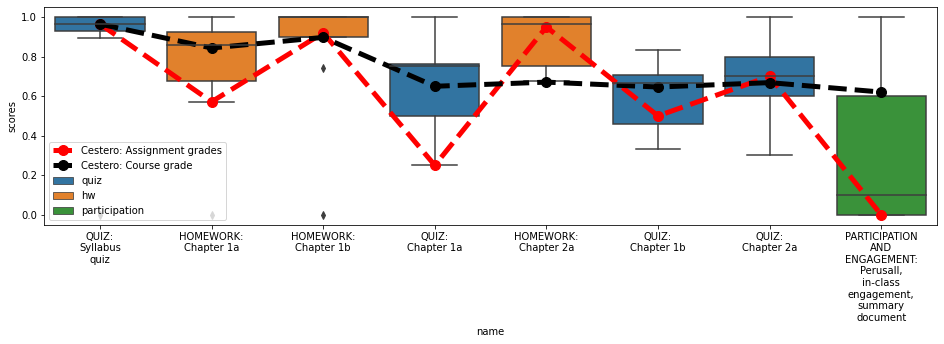

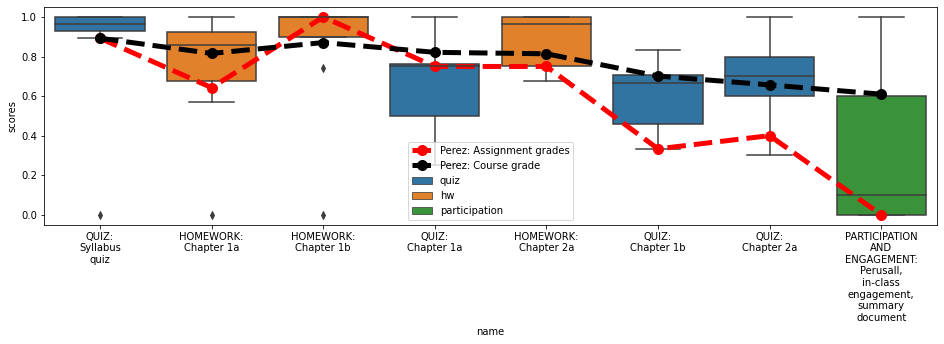

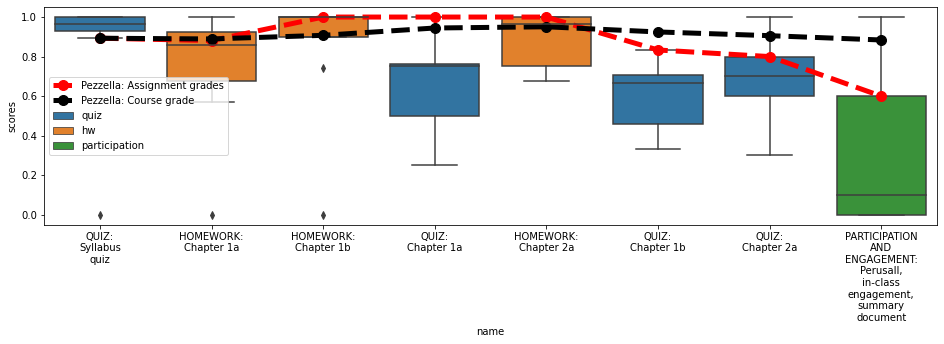

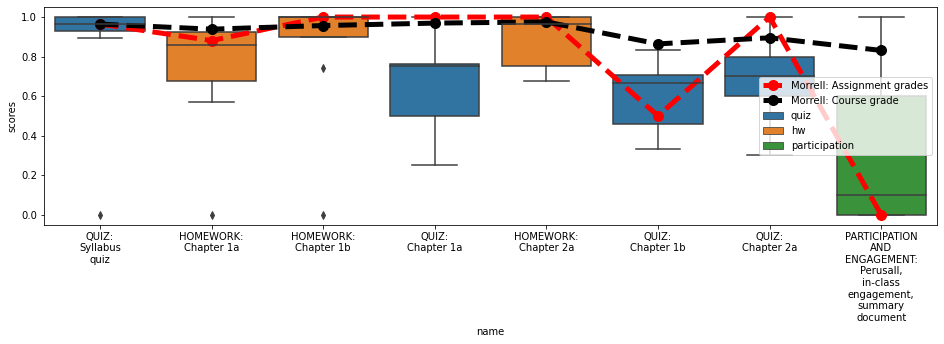

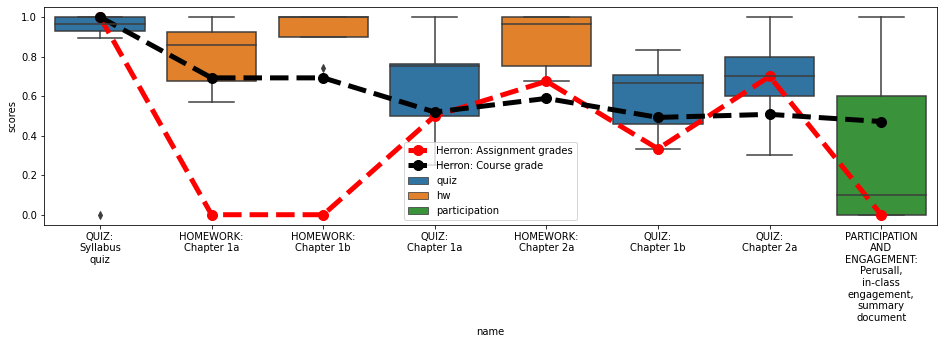

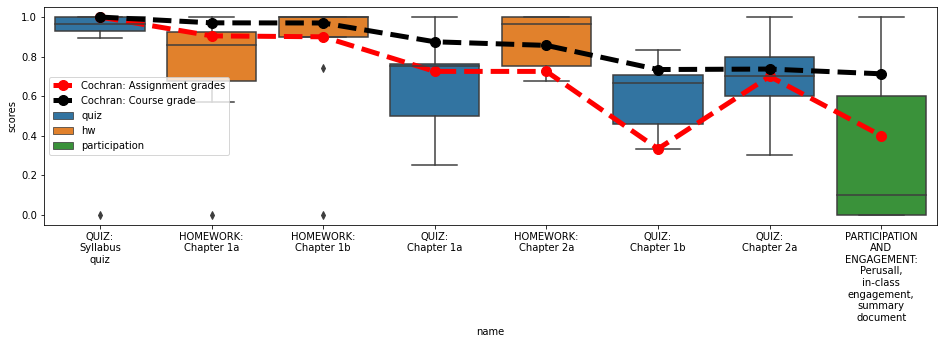

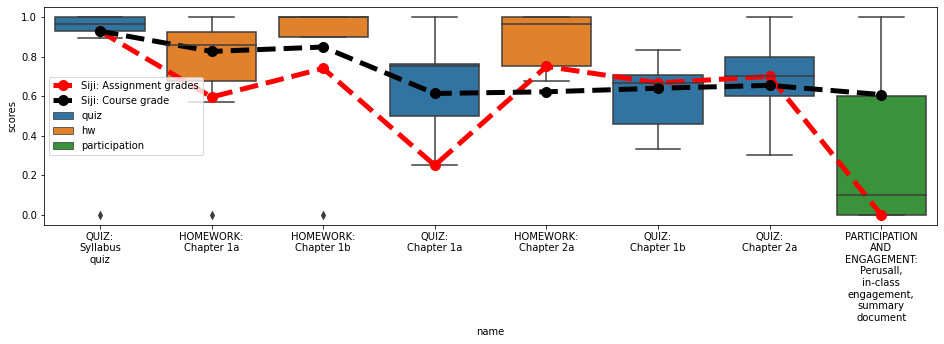

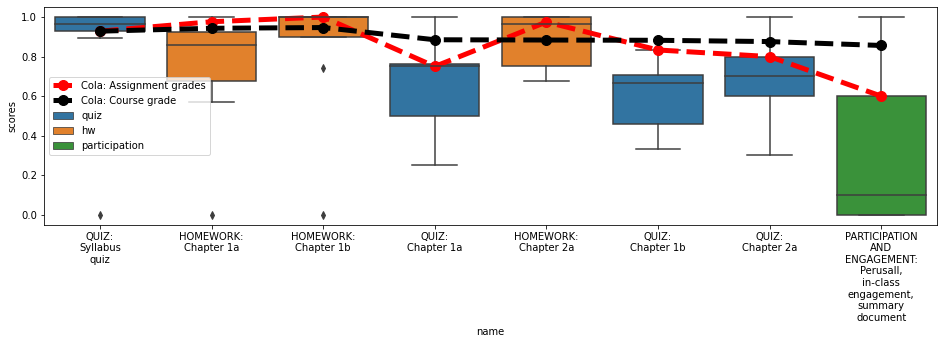

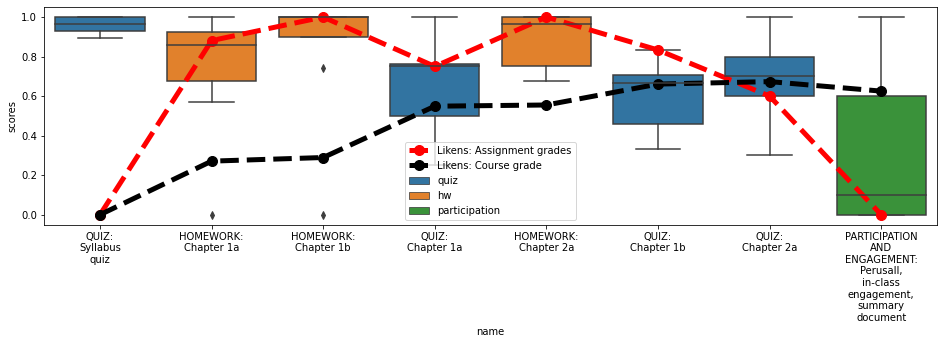

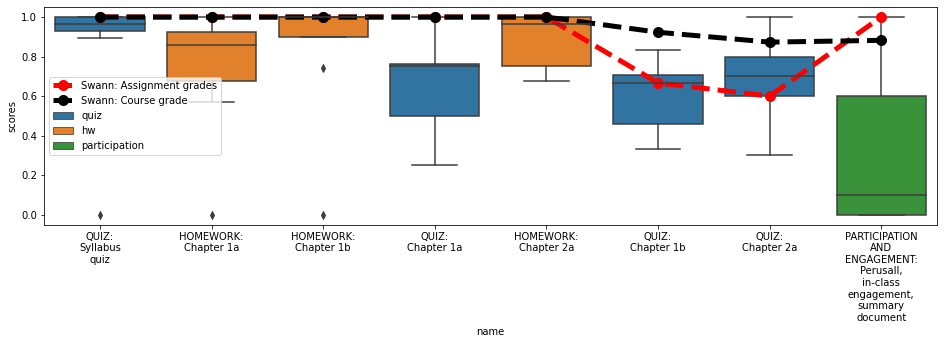

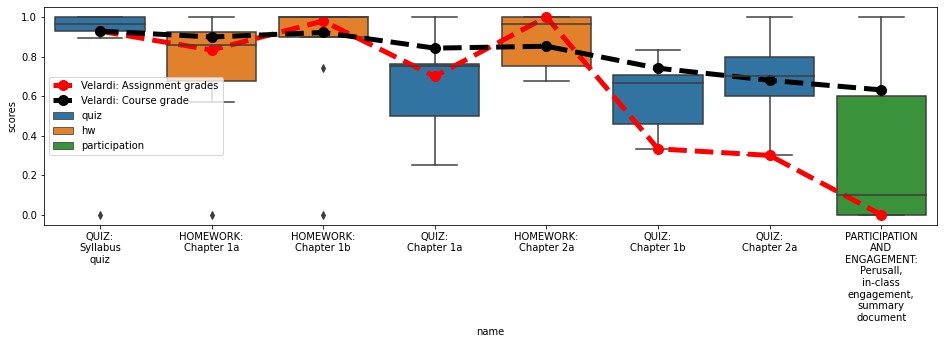

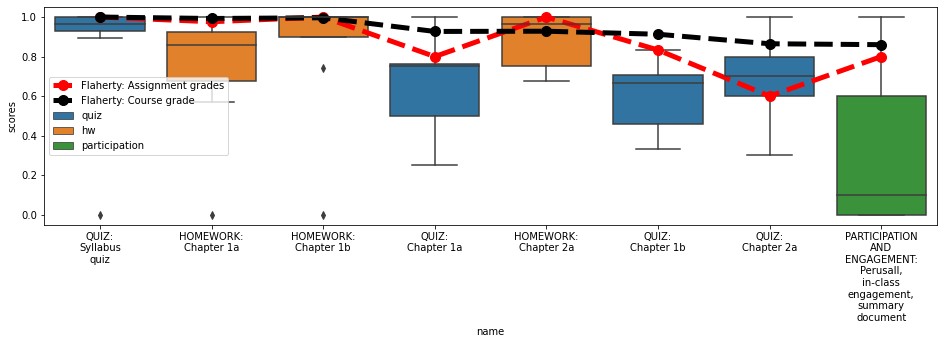

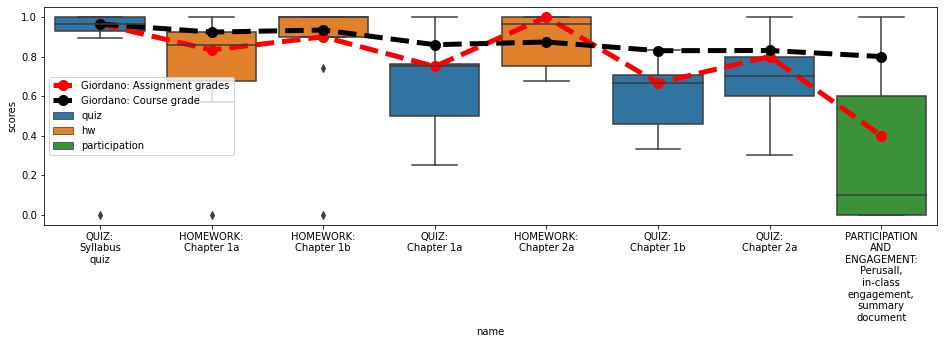

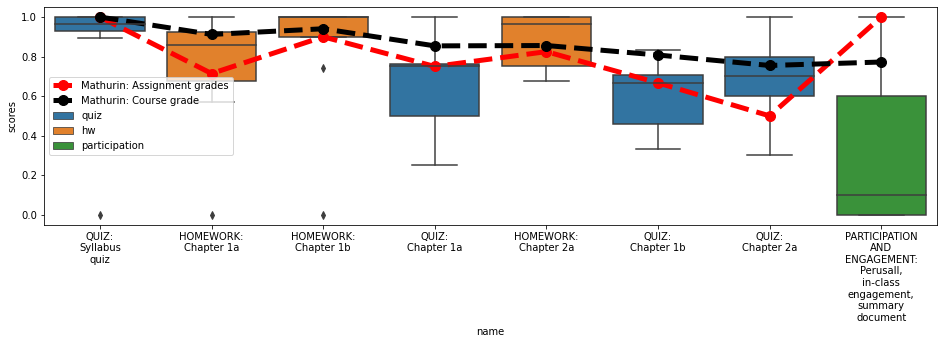

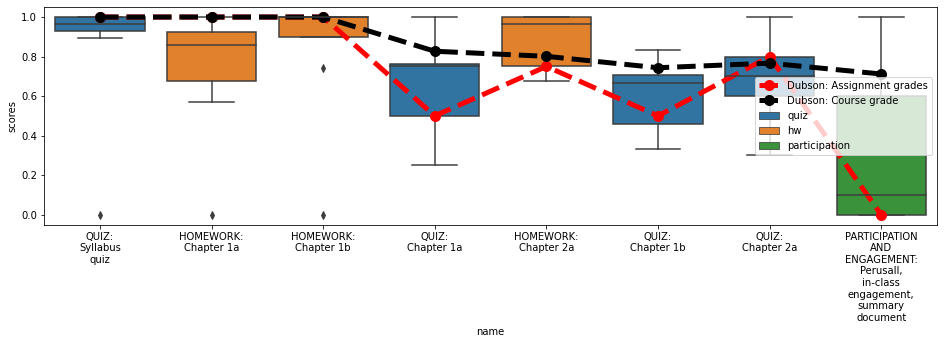

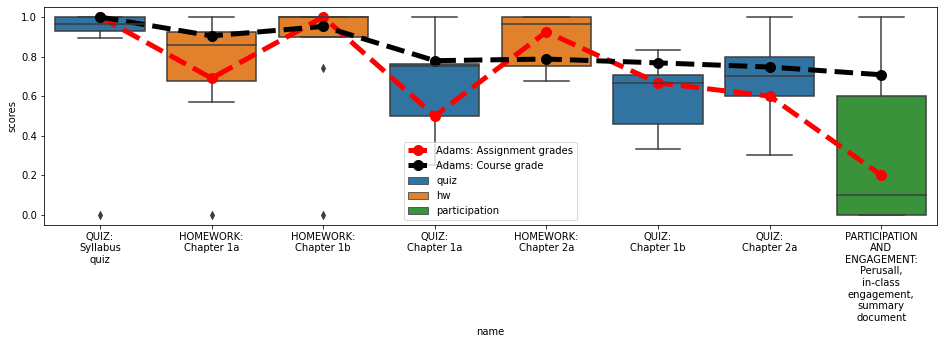

In [42]:
# Make a directory if we need to for the figures
try:
   os.makedirs("figures")
except FileExistsError:
   # directory already exists
   pass


for n in range(2,18):
    plt.figure(figsize=(16,4))

    sns.boxplot(data=dfplot, y="scores", x="name", hue='type', dodge=False);

    xlabels = plt.gca().get_xticklabels(which='both')

    xpts = []
    ypts = []
    
    dfstudent = df.iloc[n]

    scores = {}
    for key in weighting.keys():
        scores[key] = []
    #print(scores)
    
    running_aves = []

    
    lname = dfstudent['Last Name']
    fname = dfstudent['First Name']
    email = dfstudent['Email Address']

    subject = f"PHYS 260 - Thermal Physics: summary grades for {fname} {lname} ({email})\n\n"
    email_body = f"Summary grades for {fname} {lname} ({email})\n\n"
    
    for idx,xlabel in enumerate(xlabels):
        #print(xlabel)
        name = xlabel.get_text()
        #print(name)
        org_score = float(dfstudent[name])
        points = dfa[dfa['name']==name]['points'].values[0]
        score = org_score/points
        xpts.append(name)
        ypts.append(score)
        
        #print(xlabel)
        atype = dfa[dfa['name']==xlabel.get_text()]['type'].values[0]
        date = dfa[dfa['name']==xlabel.get_text()]['date'].values[0]

        #print(atype,date)
        scores[atype].append(score)
        running_ave = average_scores(scores,weighting)
        running_aves.append(running_ave)
        
        email_body += f"{name:30s} {atype:10s} {date:15s} {100*score:5.2f} ({org_score}/{points})\n"   

    #print(f"{fname} {lname} {email}")
    #print(output)
    #email_body += f"{aname} {atype} {points} {date} {score}\n")
    print(email_body)

    
    plt.plot(xpts,ypts,'ro--',markersize=10, linewidth=5, label=f'{lname}: Assignment grades');
    plt.plot(xpts,running_aves,'ko--',markersize=10, linewidth=5, label=f'{lname}: Course grade');


    plt.xticks(rotation=270,ha='center');
    plt.legend()
    wrap_labels(plt.gca(), 10)
    
    outfilename = f"figures/PHYS_260_summary_{fname}_{lname}.png"
    plt.savefig(outfilename)


In [30]:
scores = {}
for key in weighting.keys():
    scores[key] = []
print(scores)

nassignments = len(dfa)

for n in range(nassignments):
    aname = dfa.iloc[n]['name']
    atype = dfa.iloc[n]['type']
    points = dfa.iloc[n]['points']
    date = dfa.iloc[n]['date']
    
    
    org_score = float(dfstudent[aname])
    if org_score != org_score:
        continue
        
    score = org_score / points
    print(f"{aname} {atype} {points} {date} {score}")
    
    scores[atype].append(score)
    x = average_scores(scores,weighting)
    print(f"Running average: {100*x:.2f}")
    
print(scores)
    

{'quiz': [], 'hw': [], 'participation': []}
QUIZ: Syllabus quiz quiz 280.0 Jan 24, 2023 1.0
Running average: 100.00
HOMEWORK: Chapter 1a hw 42.0 Jan 26, 2023 0.6904761904761905
Running average: 90.48
HOMEWORK: Chapter 1b hw 50.0 Feb 2, 2023 1.0
Running average: 95.24
QUIZ: Chapter 1a quiz 40.0 Feb 2, 2023 0.5
Running average: 77.93
HOMEWORK: Chapter 2a hw 40.0 Feb 9, 2023 0.925
Running average: 78.75
QUIZ: Chapter 1b quiz 60.0 Feb 9, 2023 0.6666666666666666
Running average: 76.83
QUIZ: Chapter 2a quiz 50.0 Feb 16, 2023 0.6
Running average: 74.71
PARTICIPATION AND ENGAGEMENT: Perusall, in-class engagement, summary document participation 5.0 Feb 16, 2023 0.2
Running average: 70.80
{'quiz': [1.0, 0.5, 0.6666666666666666, 0.6], 'hw': [0.6904761904761905, 1.0, 0.925], 'participation': [0.2]}
